In [1]:
import torch
from torch import nn
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torchvision.transforms import v2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        torch.nn.init.kaiming_uniform_(m.weight)

class doubleConv(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.network = nn.Sequential(
    nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(inplace = True),
    nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(inplace = True)
    )
    self.network.apply(init_weights)
  def forward(self,x):
    x = self.network(x)
    return x

class downSample(nn.Module):
  def __init__(self,in_features, out_features):
    super().__init__()
    self.conv = doubleConv(in_features,out_features)
    self.pool = nn.MaxPool2d(2,2)

  def forward(self,x):
    bpx = self.conv(x)
    apx = self.pool(bpx)
    return bpx, apx

class upSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.upConv = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
    self.upConv.apply(init_weights)
    self.dConv = doubleConv(in_channels, out_channels)

  def forward(self,x,prev):
    x = self.upConv(x)
    x = torch.cat([x,prev],1)
    x = self.dConv(x)
    return x

class UNet(nn.Module):
  def __init__(self,in_channels,numOfClasses):
    super().__init__()
    self.en1 = downSample(in_channels,64)
    self.en2 = downSample(64,128)
    self.en3 = downSample(128,256)
    self.en4 = downSample(256,512)
    self.en5 = doubleConv(512,1024)

    self.de1 = upSample(1024,512)
    self.de2 = upSample(512,256)
    self.de3 = upSample(256,128)
    self.de4 = upSample(128,64)

    self.out = nn.Conv2d(64,numOfClasses,kernel_size=1)
    self.out.apply(init_weights)

  def forward(self,x):
    self.bpx1, self.apx1 = self.en1(x)
    self.bpx2, self.apx2 = self.en2(self.apx1)
    self.bpx3, self.apx3 = self.en3(self.apx2)
    self.bpx4, self.apx4 = self.en4(self.apx3)
    self.bpx5 = self.en5(self.apx4)

    x = self.de1(self.bpx5,self.bpx4)
    x = self.de2(x, self.bpx3)
    x = self.de3(x, self.bpx2)
    x = self.de4(x, self.bpx1)

    x = self.out(x)
    return x

In [3]:
imgTransforms = v2.Compose([
    v2.Resize((512,512)),
    v2.ToImage(),
    v2.ToDtype(torch.float32)
])

In [14]:
model = UNet(3,6)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Semantic Segmentation Dataset Segmentation/unet_weights_with_dice.pth', map_location = device))

<All keys matched successfully>

In [5]:
indexToColor = torch.tensor([
    [60,16,152],
    [132, 41, 246],
    [110, 193, 228],
    [254, 221, 58],
    [226, 169, 41],
    [155, 155, 155]
])
indexToColor = indexToColor.to(device)

In [10]:
def inference(imgPath, model):
  img = read_image(imgPath)
  img = imgTransforms(img)
  img = torch.unsqueeze(img,0).to(device)
  model.eval()
  with torch.no_grad():
    pred = model(img)
    pred = pred.argmax(1)
  out = indexToColor[pred]
  return out[0].cpu()

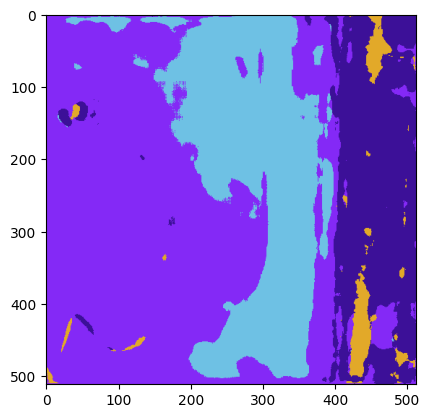

In [17]:
imagePath = '/content/drive/MyDrive/Datasets/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg'
out = inference(imagePath, model)

plt.imshow(out)